# Log data analysis

## Load data

In [10]:
import os
import time

Move raw logs in log directory by path:

In [11]:
RAW_LOG_DIR = os.path.abspath(os.getcwd()) + '/log_data/raw_data'
RAW_LOG_DIR

'/home/ivan/Projects/SL/steering_research/notebooks/../log_data/raw_data'

---

## Look at the data

In [126]:
!echo -e "$(ls {RAW_LOG_DIR} -1 | wc -l) files, $(du -h {RAW_LOG_DIR})\n" 
!echo -e "$(ls {RAW_LOG_DIR} | head -n10) \n..."

77 files, 3.9G	/home/ivan/Projects/SL/steering_research/notebooks/../log_data/raw_data

15-03-2024 10 h 00 min.log
15-03-2024 10 h 22 min.log
15-03-2024 10 h 27 min.log
15-03-2024 10 h 49 min.log
15-03-2024 11 h 10 min.log
15-03-2024 11 h 24 min.log
15-03-2024 11 h 38 min.log
15-03-2024 11 h 52 min.log
15-03-2024 12 h 07 min.log
15-03-2024 12 h 21 min.log 
...


In [127]:
def head(file_path, lines = 5):
    with open(file_path, 'r') as file:

        for _ in range(lines):     
            line = file.readline()
            if not line: break   

            print(line.strip())
        

if os.listdir(RAW_LOG_DIR):
    test_file_path = RAW_LOG_DIR + '/' + os.listdir(RAW_LOG_DIR)[0]

    head(test_file_path, 5)
else:
    print("Directory is empty")



RX 1       SFF 0x003      8 0x56 0x04 0xC3 0x08 0x00 0x00 0x01 0x00 0
RX 2       SFF 0x007      8 0xDD 0x04 0x4E 0x04 0x00 0x00 0x01 0x14 0
RX 3       SFF 0x004      8 0x57 0x04 0x04 0x0C 0x00 0x00 0x01 0x14 2
RX 4       SFF 0x005      8 0xB9 0x04 0x00 0x00 0x00 0x00 0x01 0x14 2


[RX]-[line]---[?]-[CAN_ID?]---[?]---[alpha can protocol]---[msec?]

Link: [Alpha CAN protocol docs](https://gitlab.com/starline/alpha/alpha_docs/-/blob/master/docs/can.md?ref_type=heads) 

---

## Sort data

### Sored data format


<table>
<tr>
<td width="6.25%" align="center"> </td>
<td width="6.25%" align="center"> D0  </td>
<td width="6.25%" align="center"> D1  </td>
<td width="6.25%" align="center"> D2 - D5  </td>
<td width="6.25%" align="center"> D6  </td>
<td width="6.25%" align="center"> D7  </td>
<td width="6.25%" align="center"> </td>

</tr>

<tr>
<td width="6.25%" align="center"> <b>CAN_ID</b> </td>

<td width="6.25%" align="center"> <b>CNC</b>  </td>

<td width="6.25%" align="center"> <b>TYPE</b> </td>

<td width="6.25%" align="center"> <b>CAN DATA</b> </td>

<td width="6.25%" align="center"> <b>STATE</b> </td>

<td width="6.25%" align="center"> <b>CRC</b> </td>

<td width="6.25%" align="center"> <b>TIME</b> </td>

</tr>
</table>


Exemple line:

**0x001 0x03 0x04 0x04 0x00 0x00 0x00 0x01 0x14 109741** 

Message:

- CAN_ID

- [Alpha CAN protocol](https://gitlab.com/starline/alpha/alpha_docs/-/blob/master/docs/can.md?ref_type=heads) - 8 byetes

- Time since of recording the log file, msec

### Sort process

In [128]:
import sys
import time

def progressbar(it, prefix="", size=60, out=sys.stdout): # Python3.6+
    count = len(it)
    start = time.time()
    def show(j):
        x = int(size*j/count)
        remaining = ((time.time() - start) / j) * (count - j)
        
        mins, sec = divmod(remaining, 60)
        time_str = f"{int(mins):02}:{sec:05.2f}"
        
        print(f"{prefix}[{u'█'*x}{('.'*(size-x))}] {j}/{count} Estimation wait {time_str}", end='\r', file=out, flush=True)
        
    for i, item in enumerate(it):
        yield item
        show(i+1)
    print("\n", flush=True, file=out)


In [129]:
from collections import OrderedDict

class Sorter():
    OTHER_CAN_ID_DIRNAME = "other"
    SORTER_DEBUG = False
    
    def __init__(self, raw_log_dir, sort_log_dir = None, merged_dir = None, shifted_time_dir = None):
        self._raw_log_dir     = raw_log_dir
        self._sort_log_dir    = sort_log_dir      or raw_log_dir + '/../sorted_data'
        self._merged_log_dir  = merged_dir        or raw_log_dir + '/../merged_data'
        self._shifted_log_dir = shifted_time_dir  or raw_log_dir + '/../shifted_data'

        if not os.path.exists(self._merged_log_dir):
            os.makedirs(self._merged_log_dir) 

        if not os.path.exists(self._sort_log_dir):
            os.makedirs(self._sort_log_dir)         
        
        if not os.path.exists(self._shifted_log_dir):
            os.makedirs(self._shifted_log_dir) 

    def get_raw_data_dir(self):
        return self._raw_log_dir        
    
    def get_sorted_data_dir(self):
        return self._sort_log_dir    
    
    def get_merged_data_dir(self):
        return self._merged_log_dir    
    
    def get_shifted_data_dir(self):
        return self._shifted_log_dir   


    def sort_dir(self, can_id_list, raw_dir = None):
        """
        Sort logs by can id
        """
        if not raw_dir:                            
            raw_dir = self._raw_log_dir
        
        log_files   = os.listdir(raw_dir)

        for _ in progressbar(range(len(log_files)), "Sort: ", len(log_files)):
            filename = log_files.pop()
            file_path = raw_dir + '/' + filename

            with open(file_path, 'r') as log_file:
                self.sort_file(log_file, can_id_list)
                

    def shift_time_dir(self, raw_dir = None):
        """
        shift time logs with one date
        """
        if not raw_dir:                            
            raw_dir = self._raw_log_dir

        # sort files by date
        # dict [date] = list of files
        log_files = os.listdir(raw_dir)
        by_date   = {}
        for filepath in log_files:
            filedate = self.get_file_date(filepath)

            if filedate not in by_date.keys():
                by_date[filedate] = [ filepath ]
            else: 
                by_date[filedate].append(filepath)

        # sort lists of files by abc
        for files in by_date.values():
            files.sort()

        keys = list(by_date.keys())
        for idx in progressbar(range(len(keys)), "Shift: ", len(keys)):
            merged_filepath = self._merged_log_dir + '/' + keys[0] + '.log'

            date = keys.pop(0)

            self.shift_time_files(merged_filepath, by_date[date])

        
    def shift_time_files(self, merged_filepath, filepath_list: list):
        
        is_first_file = True
        for filename in filepath_list:
            with (open(self._raw_log_dir + '/' + filename, 'r') as src_file,
                  open(self._shifted_log_dir + '/' + filename, 'a+') as dst_file):

                if is_first_file:
                    first_file_data = src_file.read()
                    dst_file.write(first_file_data)
                    
                    # get end log time
                    last_time = int(first_file_data[20:].split()[-1])  # 20 is number > spaces in last line

                    is_first_file = False
                    continue
                
                for line in src_file:
                    line = line.split()
                    
                    if not line or len(line) != 14: 
                        continue

                    # предполагаем, что во всех файлах отчет времени начинается с 0,
                    # а не с последнего значения предыдущего файла

                    local_time = int(line[-1])
                    
                    curr_time = local_time + last_time
                    line[-1] = str(curr_time)
                    dst_file.write(' '.join(line) + '\n') 

                last_time = curr_time


    def sort_file(self, log_file, can_id_list):

        self._mkdirs(can_id_list)

        sorted_filename = self._get_sorted_filename(log_file)
        open_files = {}

        # DEBUG
        bad_lines = 0  
        open_count = 0
        closed_count = 0
            
        for line in log_file:
            line = line.split()
        
            if not line or len(line) != 14: 
                bad_lines += 1
                continue

            can_id = line[3]  # protocol

            if can_id not in open_files:
                if can_id not in can_id_list:
                    dirname = self.OTHER_CAN_ID_DIRNAME
                else:
                    dirname = can_id
                
                sorted_filepath = self._sort_log_dir + '/' + dirname+ '/' + sorted_filename
                
                open_files[can_id] = open(sorted_filepath, 'a+')
                open_count += 1

            res = [ line[idx] for idx in [3] + list(range(5, 14)) ]
            open_files[can_id].write(' '.join(res))
            open_files[can_id].write('\n')

        for file in open_files.values():
            closed_count += 1
            file.close()

        if self.SORTER_DEBUG:
            print("Отбраковано строк: " + str(bad_lines))
            print("Открыто файлов: "    + str(open_count))
            print("Закрыто файлов: "    + str(closed_count))


    def _mkdirs(self, dirs_list):
    
        for dirname in dirs_list:
            new_dir_path = self._sort_log_dir + '/' + dirname

            if not os.path.exists(new_dir_path):
                os.makedirs(new_dir_path)

        # create dir for other can_id
        other_dir = self._sort_log_dir + '/' + self.OTHER_CAN_ID_DIRNAME
        if not os.path.exists(other_dir):
            os.makedirs(other_dir)    


    def _get_sorted_filename(self, file):
        # Exemple output: 19.03.2024_13:31.log

        raw_filename = os.path.basename(file.name)

        new_filename = raw_filename.replace('-',    '.', 2)
        new_filename = new_filename.replace(' h ',  ':'   )
        new_filename = new_filename.replace(' min', ''    )
        new_filename = new_filename.replace(' ',    '_', 1)

        return new_filename
         

    def get_file_date(self, filepath):
        """
        exemple: 15-03-2024
        """
        return os.path.basename(filepath)[:10]

In [130]:
s = Sorter(RAW_LOG_DIR)
s.shift_time_dir()

Shift: [███] 3/3 Est wait 00:00.00



C сортировкой разбитых файликов всё хорошо

In [131]:
can_id_list = [
    "0x001", 
    "0x002", 
    "0x003", 
    "0x004",
    "0x012", 
    "0x013", 
    "0x017", 
    "0x018", 
    "0x015",
    "0x032", 
    "0x051", 
    "0x035", 
    "0x033", 
    "0x038", 
    "0x037", 
    "0x052",
]


s = Sorter(RAW_LOG_DIR)

## Sort one file:
#file_path = raw_log_dir + '/' + os.listdir(raw_log_dir)[0]
#
#with open(file_path, 'r') as log_file:
#    s.sort_file(log_file, can_id_list)

# Sort dir:
data_dir = RAW_LOG_DIR + '/../shifted_data'
s.sort_dir(can_id_list, raw_dir=data_dir)

Sort: [█████████████████████████████████████████████████████████████████████████████] 77/77 Est wait 00:00.00



Done!

In [132]:
def get_files_count(path):
    total = 0
    for _, _, files in os.walk(path): total += len(files)

    return total

print("""
    Raw data:           {} elements     
    Sorted data:        {} elements
    Shifted data:       {} elements
    """.format(
        get_files_count(s.get_raw_data_dir()),
        get_files_count(s.get_sorted_data_dir()),
        get_files_count(s.get_shifted_data_dir())
    )
)



    Raw data:           77 elements     
    Sorted data:        1018 elements
    Shifted data:       77 elements
    


---

## Parse data

In [2]:
class AlphaData(object):  
    CAN_ID = 0x00

    def __init__(self, can_id):
        self._can_id        = self._get_can_id(can_id)
        

    def parse_line(self, line: list):
        """
        Parse data according to sorted data format
        r: ([data], time)
        """
        pass


    def get_names(self):
        """
        Return list of parsed data names. 

        (!) Names must match return values from function self.parse_file() (!)

        Exemple: return ["sw angle, [rad]", "sw vel, [rad/s]"], "time, [sec]"
        """
        pass


    def _get_can_id(self, can_id):
        return bytearray([can_id>>8, can_id & 0x00FF])
    

    def parse_file(self, file_path, shift_time_to_null = False):
        
        # check file
        if not os.path.exists(file_path):
            raise RuntimeError("No such file: " + file_path)
        
        can_id = int(os.path.basename(os.path.dirname(file_path)), 16)
        if can_id != self.CAN_ID:
            raise RuntimeError(
                "Parser {} cannot parse file with can_id {}".format(
                self.__class__.__name__, can_id)
            )
        
        # parse file
        is_first_line = True
        start_time = 0.

        time = []
        data = []

        with open(file_path, 'r') as file:
            for line in file:
                line = line.split()
    
                parsed_data = self.parse_line(line)  # data, time

                if is_first_line:
                    is_first_line = False
                    data_count = len(parsed_data[0])

                    # create lists of out data
                    for idx in range(data_count):
                        data.append([])

                    if shift_time_to_null:
                        start_time  = float(parsed_data[1])

                for idx in range(data_count):
                    data[idx].append(parsed_data[0][idx])
                
                time.append((float(parsed_data[1]) - start_time) / 1000)
        
        return data, time


Helpers

In [3]:
# x^8 + x^2 + x^1 + x^0
def calc_crc8(data):

    crc8 = 0xFF

    for byte in data:
        crc8 ^= byte

        for _ in range(8):

            if (crc8 & 0x80):
                xor_val = 0x07
            else:
                xor_val = 0x00

            crc8 = ((crc8 << 1) & 0x00FF) ^ xor_val

    return crc8


def twos_complement(value, bits):
    if value & (1 << (bits-1)):
        value -= 1 << bits
    return value

### CAN ID 0x001

In [4]:
class CAN0x001(AlphaData):
    CAN_ID = 0x001

    def __init__(self,  *args, **kwargs):
        super(CAN0x001, self).__init__(can_id=self.CAN_ID, *args, **kwargs)
 
 
    def parse_file(self, file_path, shift_time_to_null = False):
        return super(CAN0x001, self).parse_file(file_path, shift_time_to_null = False)


    def parse_line(self, line: list):
        """
        r: ([angle, vel], time)
        """
        
        # Cast ACP list to bytearray
        can_id = self._get_can_id(int(line[0], 16))
        acp    = [ int(line[idx], 16) for idx in range(1, 9)]
            
        # Valid data
        if (can_id != self._can_id  or len(line) != 10):
            print('not valid')
            print(self._can_id, self._can_type)
            return None, None
        
        # CRC
        #if (acp[7] != calc_crc8(acp[0:7])):
        #    print("Wrong crc!")
        #    return None, None

        cnc    = line[1]
        state  = line[7]  
        time   = line[9]

        angle = twos_complement((acp[3] << 8) + acp[2], 16)
        vel   = twos_complement((acp[5] << 8) + acp[4], 16)

        return [angle, vel], time
    
    
    def get_names(self):
        return ["sw angle, [deg]", "sw vel, [deg/s]"], "time, [sec]"

In [5]:
# from log file
l1 = ['0x001', '0x2B', '0x04', '0xFC', '0xFF', '0x00', '0x00', '0x01', '0x14', '0']
l2 = ['0x001', '0x2D', '0x04', '0xFD', '0xFF', '0x00', '0x00', '0x01', '0x14', '1']
l3 = ['0x001', '0x2E', '0x04', '0xFD', '0xFF', '0x00', '0x00', '0x01', '0x14', '3']

# from simulation 
l4 = ['0x001', '0xFF', '0x4', '0xC7', '0xFE', '0x0', '0x0', '0x1', '0x1E', '4']  # -313
l5 = ['0x001', '0xFF', '0x4', '0xCE', '0xFE', '0x0', '0x0', '0x1', '0x78', '5']  # -306


parser = CAN0x001()

print(parser.parse_line(l1))
print(parser.parse_line(l2))
print(parser.parse_line(l3))

print(parser.parse_line(l4))
print(parser.parse_line(l5))

([-4, 0], '0')
([-3, 0], '1')
([-3, 0], '3')
([-313, 0], '4')
([-306, 0], '5')


### CAN ID 0x032

In [6]:
class CAN0x032(AlphaData):
    CAN_ID = 0x032

    LEFT  = 0x02
    RIGHT = 0x01

    MAX_TORQUE = 1000


    def __init__(self,  *args, **kwargs):
        super(CAN0x032, self).__init__(can_id=self.CAN_ID, *args, **kwargs)
 
 
    def parse_file(self, file_path, shift_time_to_null = False):
        return super(CAN0x032, self).parse_file(file_path, shift_time_to_null = False)
    

    def parse_line(self, line: list):
        """
        r: ([torque], time)
        """
        
        # Cast ACP list to bytearray
        can_id = self._get_can_id(int(line[0], 16))
        acp    = [ int(line[idx], 16) for idx in range(1, 9)]
            
        # Valid data
        if (can_id != self._can_id  or len(line) != 10):
            return None, None
        
        # CRC
        #if (acp[7] != calc_crc8(acp[0:7])):
        #    print("Wrong crc!")
        #    return None, None

        cnc    = line[1]
        state  = line[7] 
        time   = line[9]

        torque_abs = (acp[4] + (acp[5] << 8)) 
        torque = torque_abs if acp[3] == self.LEFT else -torque_abs

        return [torque / 10], time
    

    def get_names(self):
        return ["torque, [-100;100]"], "time, [sec]"

In [7]:
# from simulation
l1 = ['0x032', '0xFF', '0x2',	'0x0',	'0x1',	'0x8C', '0x0', '0x1',	'0xB2', '500701']  # -140
l2 = ['0x032', '0xFF', '0x2',   '0x0',  '0x2',  '0x64', '0x0', '0x1',   '0x17', '111'   ]  # 100
l3 = ['0x032', '0x25', '0x02', '0x01', '0x01', '0x00', '0x00', '0x01',  '0x5A', '9099'  ]  # -0

parser = CAN0x032()

print(parser.parse_line(l1))
print(parser.parse_line(l2))
print(parser.parse_line(l3))

([-14.0], '500701')
([10.0], '111')
([0.0], '9099')


In [12]:
can_dir        = RAW_LOG_DIR + '/../sorted_data/0x032/'
test_file_path = can_dir + os.listdir(can_dir)[0]

parser = CAN0x032()

with open(test_file_path, 'r') as file:
    line = file.readline().split()

    print("input line: \n{}\n".format(line))
    res = parser.parse_line(line)
    print(res)

input line: 
['0x032', '0xFF', '0x02', '0x00', '0x01', '0x30', '0x00', '0x01', '0xA2', '4203374']

([-4.8], '4203374')


### CAN ID 0x003

In [13]:
class CAN0x003(AlphaData):
    CAN_ID = 0x003

    def __init__(self,  *args, **kwargs):
        super(CAN0x003, self).__init__(can_id=self.CAN_ID, *args, **kwargs)
 
 
    def parse_file(self, file_path, shift_time_to_null = False):
        return super(CAN0x003, self).parse_file(file_path, shift_time_to_null = False)
    

    def parse_line(self, line: list):
        """
        r: ([speed, acc], time)
        """
        
        # Cast ACP list to bytearray
        can_id = self._get_can_id(int(line[0], 16))
        acp    = [ int(line[idx], 16) for idx in range(1, 9)]
            
        # Valid data
        if (can_id != self._can_id  or len(line) != 10):
            return None, None
        
        # CRC
        #if (acp[7] != calc_crc8(acp[0:7])):
        #    print("Wrong crc!")
        #    return None, None

        cnc    = line[1]
        state  = line[7] 
        time   = line[9]

        speed = twos_complement((acp[3] << 8) + acp[2], 16) / 100
        acc   = twos_complement((acp[5] << 8) + acp[4], 16) / 100

        return [speed, acc], time


    def get_names(self):
        return ["speed, [m/s]", "acc, [m/s^2]"], "time, [sec]"

In [14]:
l1 = ['0x003', '0x43', '0x04', '0x40', '0x05', '0x00', '0x00', '0x01', '0x14', '1635']
l2 = ['0x003', '0x45', '0x04', '0x35', '0x05', '0x00', '0x00', '0x01', '0x14', '1636']
l3 = ['0x003', '0x47', '0x04', '0x3A', '0x05', '0x00', '0x00', '0x01', '0x14', '1636']

parser = CAN0x003()

print(parser.parse_line(l1))
print(parser.parse_line(l2))
print(parser.parse_line(l3))

([13.44, 0.0], '1635')
([13.33, 0.0], '1636')
([13.38, 0.0], '1636')


### CAN ID 0x015

In [15]:
class CAN0x015(AlphaData):
    CAN_ID = 0x015

    LED_ON  = 0x01
    LED_OFF = 0x02

    EMERGENCY_STOP_ON  = 0x01
    EMERGENCY_STOP_OFF = 0x02

    HAND_BRAKE_ON  = 0x01
    HAND_BRAKE_OFF = 0x02


    def __init__(self,  *args, **kwargs):
        super(CAN0x015, self).__init__(can_id=self.CAN_ID, *args, **kwargs)
 
 
    def parse_file(self, file_path, shift_time_to_null = False):
        return super(CAN0x015, self).parse_file(file_path, shift_time_to_null = False)
    

    def parse_line(self, line: list):
        """
        r: ([veh_state], time)

        veh_state - Состояние системы Старт / Стоп:
            0x00 - Неизвестное состояние
            0x02 - Перехват активирован (режим D)
            0x03 - Перехват активирован (режим R)
            0x04 - Перехват не активирован
        """
        
        # Cast ACP list to bytearray
        can_id = self._get_can_id(int(line[0], 16))
        acp    = [ int(line[idx], 16) for idx in range(1, 9)]
            
        # Valid data
        if (can_id != self._can_id  or len(line) != 10):
            return None, None
        
        # CRC
        #if (acp[7] != calc_crc8(acp[0:7])):
        #    print("Wrong crc!")
        #    return None, None

        cnc    = acp[0]
        state  = acp[6] 
        time   = line[9]

        # TAKEOVER_BUTTON in string:
        takeover_button = bin(acp[2])[2:].rjust(8, '0')

        available = int(takeover_button[6] + takeover_button[7], 2)
        source    = int(takeover_button[3] + takeover_button[4] + takeover_button[5], 2)
        veh_state = int(takeover_button[0] + takeover_button[1] + takeover_button[2], 2)

        led        = acp[3] == self.LED_ON
        emer_brake = acp[4] == self.EMERGENCY_STOP_ON
        hand_brake = acp[5] == self.HAND_BRAKE_ON

        return [veh_state], time  # TODO: add other
    

    def get_names(self):
        return ["veh_state"], "time, [sec]"

In [16]:
l1 = ['0x015', '0x6F', '0x01', '0x6C', '0x02', '0x40', '0x40', '0x00', '0x3F', '2166']

parser = CAN0x015()

print(parser.parse_line(l1))

([3], '2166')


## Plots

Install dependencies:

In [144]:
!pip install ipympl >> /dev/null
!if [ $? -eq 0 ]; then echo success!; else echo failure! ; fi

success!


In [145]:
import random

import inspect, sys

import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np


In [146]:
%matplotlib widget

class Plotter():
    FULL_SCREEN = 17
    HALF_SCREEN = 8

    def __init__(self, title = "Plot"):
        self._title = title
        self._parser = None

    
    def _get_random_color(self):
        return "#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
    

    def plot_list(self, input_data: list, merge_plots = False):
        """
        param: input_data: [[x_data1, y_data1, label1], [x_data2, y_data2, label2], ...]
        """
        # set subplots params
        subplots_count = 1 if merge_plots else len(input_data)

        self.fig, ax = plt.subplots(subplots_count, 1, figsize=[self.FULL_SCREEN, subplots_count * 8.0], facecolor='#E0E0E0')

        self.ax = ax if type(ax) == type(np.array([])) else [ax]

        plt.subplots_adjust(bottom=0.05, right=0.98, top=0.96, left=0.04)
        plt.tight_layout()
        plt.title(self._title)

        for idx, data in enumerate(input_data):
            if merge_plots: idx = 0

            curr_plot, = self.ax[idx].plot([], [], color=self._get_random_color(), lw=2, ls='-', label=data[2])
            curr_plot.set_data(data[0], data[1])
            
            self.ax[idx].grid(True, color='#E0E0E0')
            self.ax[idx].set_xlabel('time, [s]')
            self.ax[idx].set_ylabel('data')

            # axis scale
            self.ax[idx].relim() 
            self.ax[idx].autoscale()

            ## legend
            self.ax[idx].legend().get_frame().set_facecolor('#E0E0E0')

        plt.show()


    def _set_parser(self, can_id):

        classname = 'CAN' + str(can_id)

        classes = {}
        for name, class_type in inspect.getmembers(sys.modules[__name__]):
            if inspect.isclass(class_type): 
                classes.update({name: class_type})

        if (classname in classes):
            self._parser = classes[classname]()

        else:
            raise RuntimeError("There is no " + str(classname) + " handler")
        

    def _clear_parser(self):
        self._parser = None


    def plot_file(self, file_path_list: list, merge_plots = False):
        data_to_plot = self.file_to_list(file_path_list, merge_plots)
        
        self.plot_list(data_to_plot, merge_plots)


    def file_to_list(self, file_path_list: list, merge_plots = False):
        """

        """
        
        data_to_plot = []

        prev_parser = self._parser

        for file_path in file_path_list:

            # check file
            if not os.path.exists(file_path):
                raise RuntimeError("No such file: " + file_path)

            # create parser obj for curr can_id
            can_id = os.path.basename(os.path.dirname(file_path))

            self._set_parser(can_id)

            # parse
            data_list, time = self._parser.parse_file(file_path)

            # write to list
            names = self._parser.get_names()

            for data, name in zip(data_list, names[0]):
                data_to_plot.append([time, data, name])     

        self._parser = prev_parser
        
        return data_to_plot      



### Let's test it!

In [1]:
p = Plotter()

# File 1 
dir_1  = RAW_LOG_DIR + '/../sorted_data/0x032/'
path_1 = dir_1 + os.listdir(dir_1)[0]

# File 2
dir_2  = RAW_LOG_DIR + '/../sorted_data/0x001/'
path_2 = dir_2 + os.listdir(dir_2)[3]

p.plot_file([path_1, path_2], False)

NameError: name 'Plotter' is not defined

Merge:

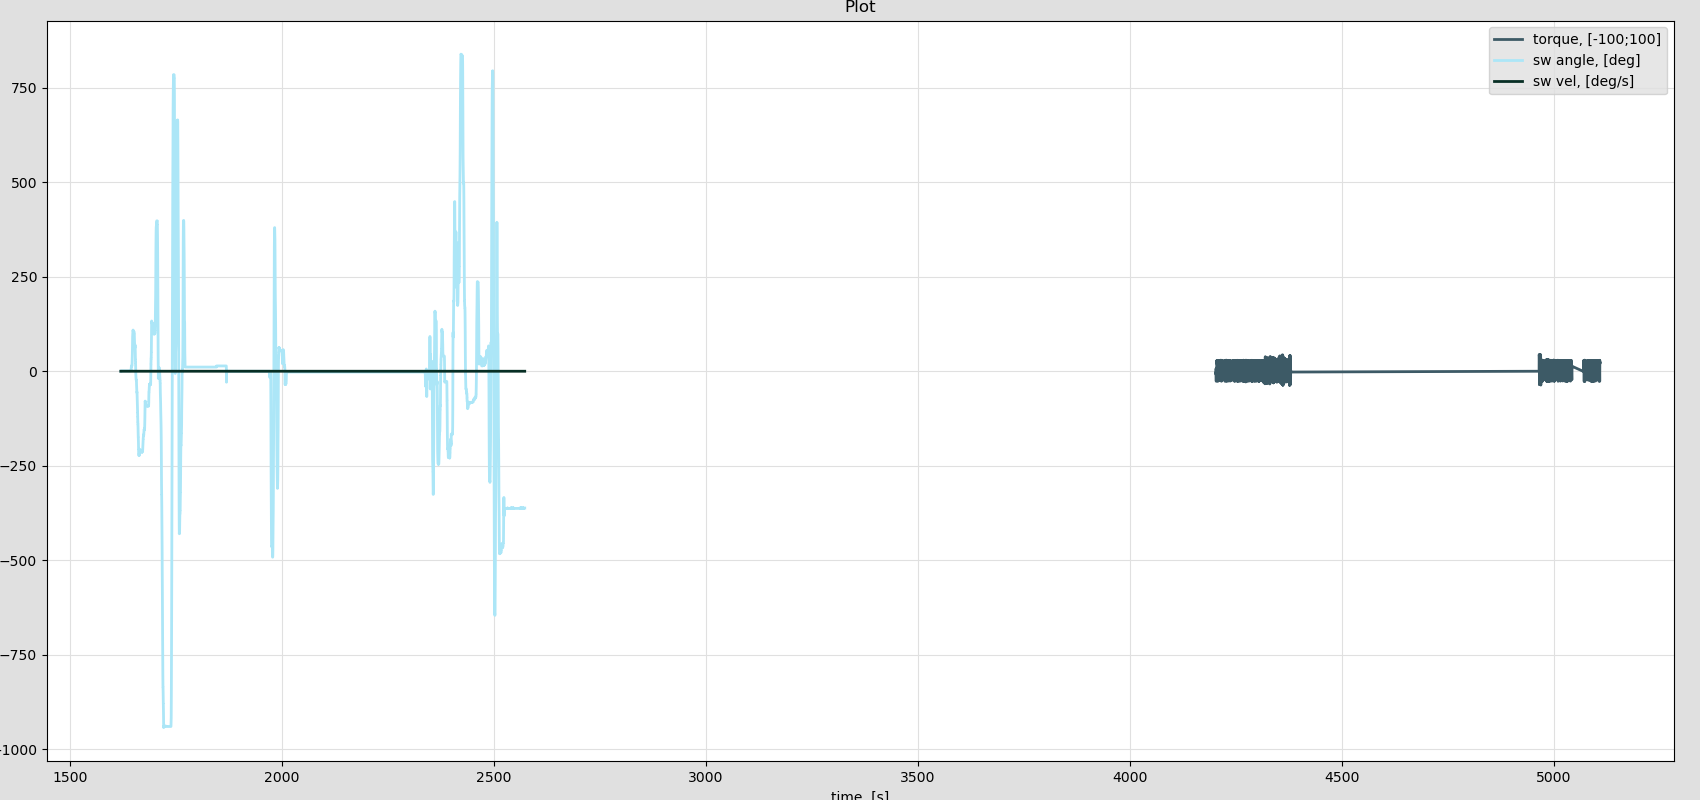

In [148]:
p = Plotter()

# File 1 
dir_1  = RAW_LOG_DIR + '/../sorted_data/0x032/'
path_1 = dir_1 + os.listdir(dir_1)[0]

# File 2
dir_2  = RAW_LOG_DIR + '/../sorted_data/0x001/'
path_2 = dir_2 + os.listdir(dir_2)[0]


p.plot_file([path_1, path_2], True)

### \* ребенку дают макер ***
###
### стена через 0.1 секунду:

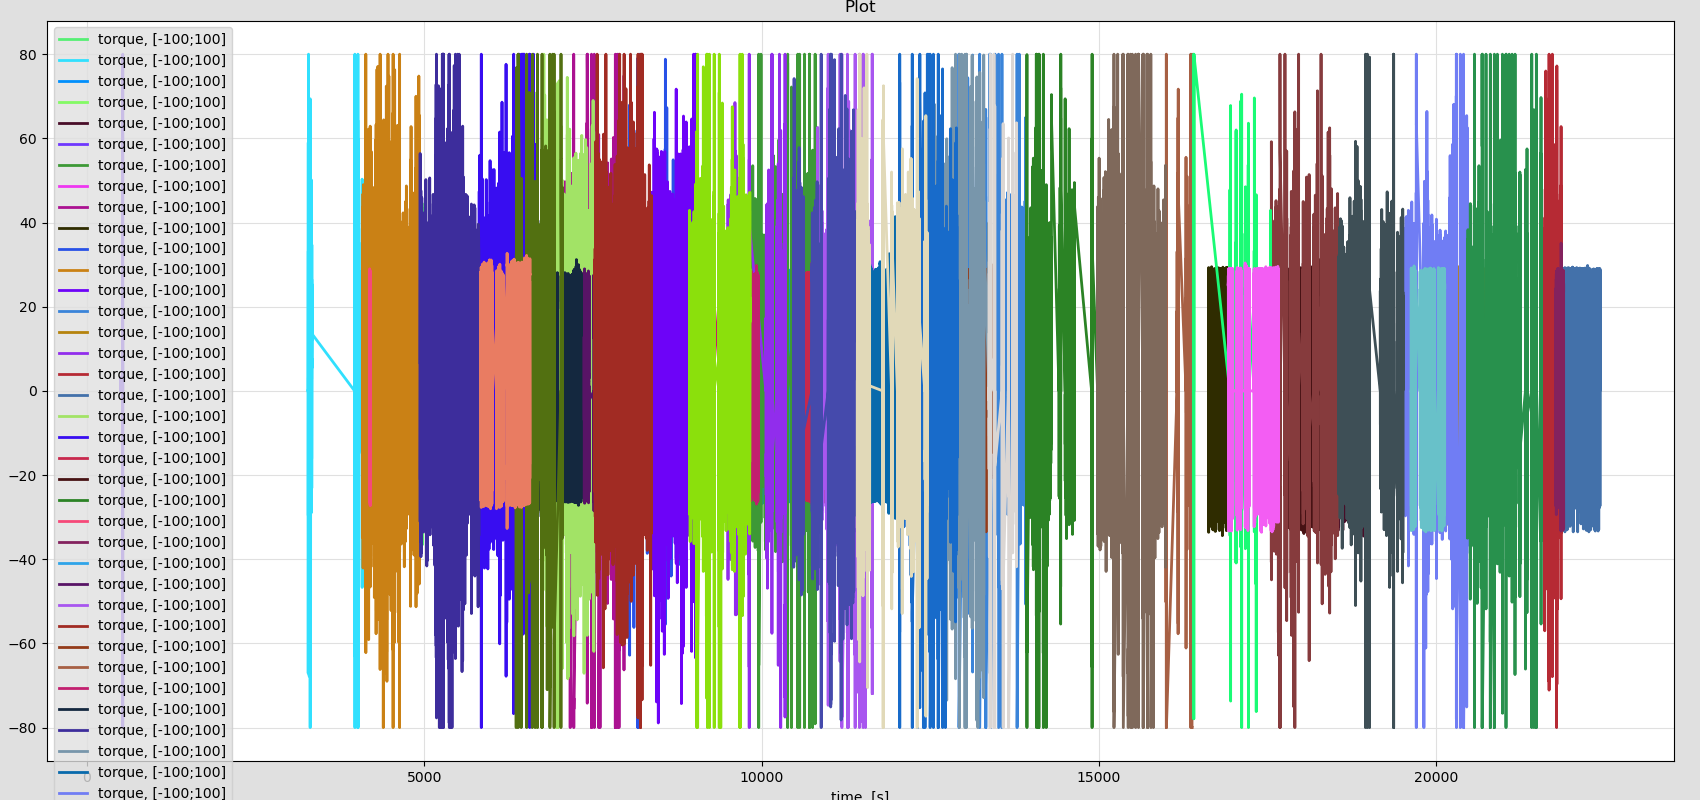

In [149]:
p = Plotter()

dir  = RAW_LOG_DIR + '/../sorted_data/0x032/'
files = [dir + el for el in os.listdir(dir)]

p.plot_file(files, True)

## Steering wheel data


### Select data

In [150]:
date = "15.03.2024"

can_id_list = [
    "0x001",
    "0x032"

]

/home/ivan/.local/lib/python3.10/site-packages/ipympl/backend_nbagg.py:336: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  self.figure.savefig(buf, format='png', dpi='figure')


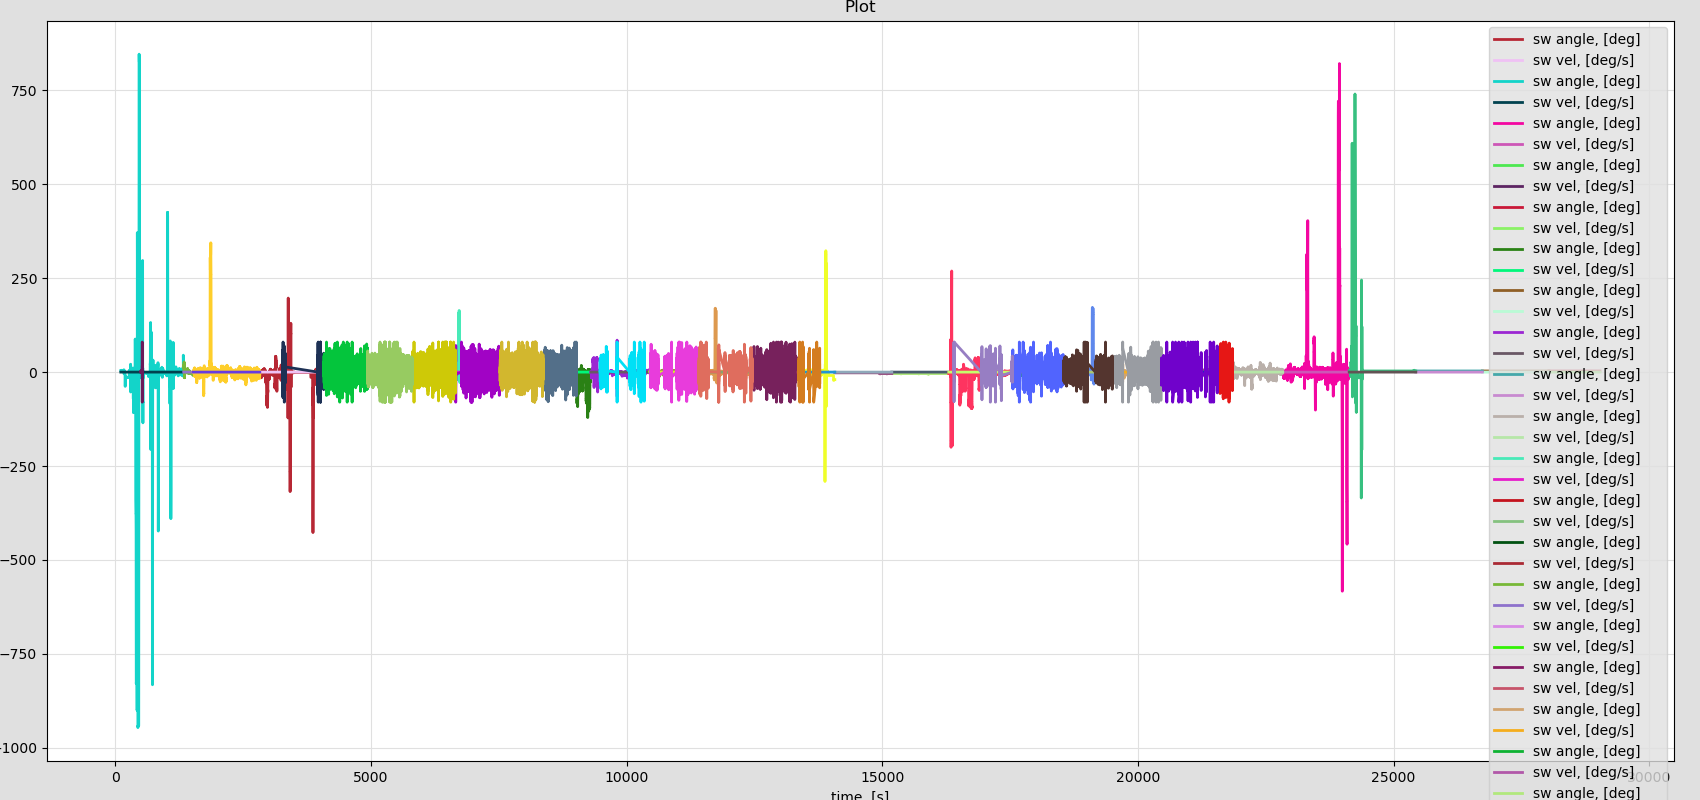

In [151]:
def get_date(filepath):
    return os.path.basename(filepath)[:10]


# select files
can_dir = RAW_LOG_DIR + '/../sorted_data/'

files = []

for can_id in can_id_list:
    for filename in os.listdir(can_dir + can_id):
        if get_date(filename) == date:
            files.append(can_dir + can_id + '/' + filename)

# plot it!
p = Plotter()

p.plot_file(files, True)